In [134]:
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import random
import os
import xgboost as xgb

from joblib import dump
from optuna.samplers import TPESampler
from sklearn.preprocessing import MinMaxScaler

# Fix random seed
seed = 42
np.random.seed(seed)
random.seed(seed)
sampler = TPESampler(seed=seed)

optuna.logging.set_verbosity(optuna.logging.WARNING)

HYPERPARAMETERS_SEARCH = False

# Pre-processing input data

In [135]:
# train_df and test_df are created in eda notebook
if not os.path.exists('csv/train_df.csv') or not os.path.exists('csv/test_df.csv'):
	print('Please run the eda notebook first')
	exit()
train_df = pd.read_csv('csv/train_df.csv')
test_df = pd.read_csv('csv/test_df.csv')
target = 'total_time_target'
features = test_df.columns.copy().drop(target).drop(['benchmark','brand_raw', 'brand_raw_target','vendor_id_raw', 'arch'])

# Spearman U Kendall correlation feature selection > 0.4
# features = ["total_time","max_ram_usage","brk","munmap","rss","vms","shared","data"]
# mean error: 2.6298196518300885 | std error: 6.704351557190401

# log for total_times
train_df[[target, 'total_time']] = np.log1p(train_df[[target, 'total_time']])
test_df[[target, 'total_time']] = np.log1p(test_df[[target, 'total_time']])

# Split data
X_train = train_df[features]
y_train = train_df[target]

X_test = test_df[features]
y_test = test_df[target]

# Normalize data
x_scaler = MinMaxScaler(feature_range=(0, 1))
X_train = x_scaler.fit_transform(X_train)
X_test = x_scaler.transform(X_test)
y_scaler = MinMaxScaler(feature_range=(0, 1))
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test = y_scaler.transform(y_test.values.reshape(-1, 1))

In [136]:
if not os.path.exists('../models/x_scaler.joblib') or not os.path.exists('../models/y_scaler.joblib'):
	dump(x_scaler, '../models/x_scaler.joblib')
	dump(y_scaler, '../models/y_scaler.joblib')

# Model: XGBoost

In [137]:
def inv_scaling(y, y_scaler):
    return y_scaler.inverse_transform(y.reshape(-1, 1))

# Hyperparameters Optimization

In [138]:
def objective(trial: optuna.Trial, X_train, y_train, X_test, y_test):
	dtrain = xgb.DMatrix(X_train, label=y_train)
	dtest = xgb.DMatrix(X_test, label=y_test)
	
	# Definimos los hiperparámetros a buscar (XGBoost)
	param = {
		"verbosity": 0,
		"device": "cuda",
		"objective": "reg:squarederror",
		"eval_metric": "rmse",
		"booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
		# L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
		"learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
	}
	num_boost_round = trial.suggest_int("num_boost_round", 10, 1000, step=10)
    
	if param["booster"] in ["gbtree", "dart"]:
		# maximum depth of the tree, signifies complexity of the tree.
		param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
		# minimum child weight, larger the term more conservative the tree.
		param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
		param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
		# defines how selective algorithm is.
		param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
		param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

	if param["booster"] == "dart":
		param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
		param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
		param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
		param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

	# training
	evals_result = {}
	xgb.train(
		param, 
		dtrain,
		num_boost_round=num_boost_round,
		evals=[(dtrain, "train"), (dtest, "test")],
		evals_result=evals_result,
		verbose_eval=False,
		early_stopping_rounds=25
	)
	loss = evals_result['train']['rmse'][-1]
	val_loss = evals_result['test']['rmse'][-1]
	print(f"Trial: {trial.number} - RMSE Loss : {loss} - RMSE Val Loss: {val_loss}")
	return val_loss

n_trials = 100
study = None

In [139]:
if HYPERPARAMETERS_SEARCH:
	study = optuna.create_study(direction='minimize', sampler=sampler)
	study.optimize(lambda trial: objective(trial, X_train, y_train, X_test, y_test), n_trials=n_trials)

In [140]:
if study is not None:
	print(f'Number of trials: {len(study.trials)}')
	trial = study.best_trial
	print(f'Best trial: {trial.number}')
	print(f'Best params: {trial.params}')
	print(f'Best validation loss: {np.reshape(trial.value, (-1,1)).item()}')

# Training

In [141]:
# hyperparameters
params = {
	"device": "cuda",
	"objective": "reg:squarederror",
	"eval_metric": "rmse",
}
if study is not None:
	num_boost_round = study.best_trial.params['num_boost_round']
	params.update(*study.best_trial.params)
	params.pop('num_boost_round')
else:
	num_boost_round = 100

In [142]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

evals_result = {}
model = xgb.train(
	params, 
	dtrain,
	num_boost_round=num_boost_round,
	evals=[(dtrain, "train"), (dtest, "test")],
	evals_result=evals_result,
	early_stopping_rounds=10
)

[0]	train-rmse:0.15802	test-rmse:0.15848
[1]	train-rmse:0.11129	test-rmse:0.11197
[2]	train-rmse:0.07870	test-rmse:0.07953
[3]	train-rmse:0.05599	test-rmse:0.05689
[4]	train-rmse:0.04023	test-rmse:0.04140
[5]	train-rmse:0.02938	test-rmse:0.03124
[6]	train-rmse:0.02185	test-rmse:0.02354
[7]	train-rmse:0.01677	test-rmse:0.01890
[8]	train-rmse:0.01345	test-rmse:0.01592
[9]	train-rmse:0.01120	test-rmse:0.01318
[10]	train-rmse:0.00974	test-rmse:0.01165
[11]	train-rmse:0.00878	test-rmse:0.01107
[12]	train-rmse:0.00814	test-rmse:0.01064
[13]	train-rmse:0.00765	test-rmse:0.01024
[14]	train-rmse:0.00730	test-rmse:0.00967
[15]	train-rmse:0.00697	test-rmse:0.00946
[16]	train-rmse:0.00651	test-rmse:0.00914
[17]	train-rmse:0.00635	test-rmse:0.00902
[18]	train-rmse:0.00620	test-rmse:0.00894
[19]	train-rmse:0.00600	test-rmse:0.00855
[20]	train-rmse:0.00583	test-rmse:0.00850
[21]	train-rmse:0.00574	test-rmse:0.00840
[22]	train-rmse:0.00567	test-rmse:0.00824
[23]	train-rmse:0.00547	test-rmse:0.00813
[2

[27]	train-rmse:0.00510	test-rmse:0.00785
[28]	train-rmse:0.00501	test-rmse:0.00781
[29]	train-rmse:0.00497	test-rmse:0.00776
[30]	train-rmse:0.00492	test-rmse:0.00779
[31]	train-rmse:0.00483	test-rmse:0.00770
[32]	train-rmse:0.00481	test-rmse:0.00761
[33]	train-rmse:0.00472	test-rmse:0.00757
[34]	train-rmse:0.00469	test-rmse:0.00756
[35]	train-rmse:0.00462	test-rmse:0.00754
[36]	train-rmse:0.00454	test-rmse:0.00751
[37]	train-rmse:0.00449	test-rmse:0.00748
[38]	train-rmse:0.00441	test-rmse:0.00746
[39]	train-rmse:0.00440	test-rmse:0.00745
[40]	train-rmse:0.00438	test-rmse:0.00740
[41]	train-rmse:0.00435	test-rmse:0.00742
[42]	train-rmse:0.00428	test-rmse:0.00736
[43]	train-rmse:0.00426	test-rmse:0.00734
[44]	train-rmse:0.00424	test-rmse:0.00730
[45]	train-rmse:0.00422	test-rmse:0.00731
[46]	train-rmse:0.00420	test-rmse:0.00730
[47]	train-rmse:0.00418	test-rmse:0.00729
[48]	train-rmse:0.00416	test-rmse:0.00728
[49]	train-rmse:0.00414	test-rmse:0.00727
[50]	train-rmse:0.00412	test-rmse:

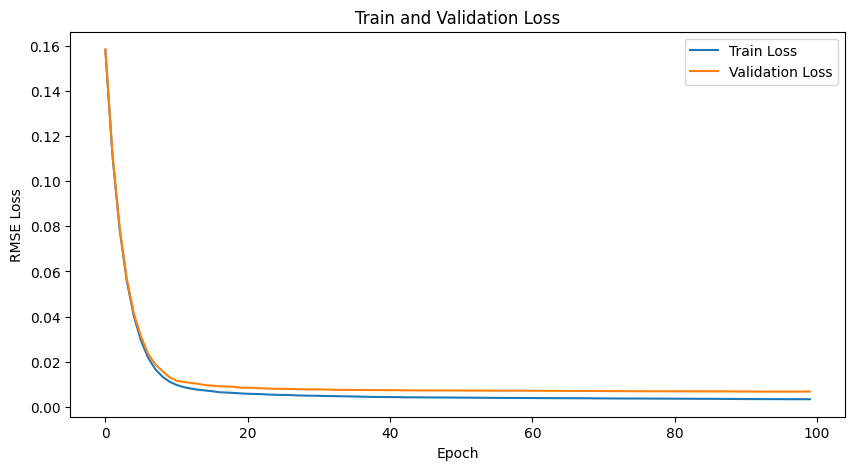

In [143]:
# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(evals_result['train']['rmse'], label='Train Loss')
plt.plot(evals_result['test']['rmse'], label='Validation Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('RMSE Loss')
plt.legend()
plt.show()

In [144]:
# save model
model.save_model(f'../models/xgboost_model.json')

# Describe Validation

In [145]:
model = xgb.Booster()
model.load_model('../models/xgboost_model.json')

In [146]:
def describe_val(model, X, y, y_scaler):
	min_instance = {"prediction": float('inf'), "actual": 0, "index": 0}
	max_instance = {"prediction": 0, "actual": 0, "index": 0}
	dtest = xgb.DMatrix(X)
	predictions = model.predict(dtest)
	predictions = np.expm1(inv_scaling(predictions, y_scaler))
	y_scaled = np.expm1(inv_scaling(y, y_scaler))
	index_min = np.argmin(np.abs(predictions - y_scaled))
	min_instance["prediction"] = predictions[index_min].item()
	min_instance["actual"] = y_scaled[index_min].item()
	min_instance["index"] = index_min
	index_max = np.argmax(np.abs(predictions - y_scaled))
	max_instance["prediction"] = predictions[index_max].item()
	max_instance["actual"] = y_scaled[index_max].item()
	max_instance["index"] = index_max

	return min_instance, max_instance, predictions

In [147]:
test_df_og = pd.read_csv('csv/test_df.csv')

In [148]:
_, _, predictions = describe_val(model, X_test, y_test, y_scaler)
y_scaled = np.expm1(inv_scaling(y_test, y_scaler))
df = pd.DataFrame(predictions, columns=['predictions'])
df['actual'] = y_scaled
df.to_csv('csv/predictions_xgboost.csv', index=False)

In [149]:
print("Validation set single thread model")
min_instance, max_instance, predictions = describe_val(model, X_test, y_test, y_scaler)
y_scaled = np.expm1(inv_scaling(y_test, y_scaler))
errors = np.abs(predictions - y_scaled)
mean_error = np.mean(errors)
std_error = np.std(errors)

print(f"Mean prediction: {np.mean(predictions)} | Std actual: {np.std(predictions)}")
print(f"Mean actual: {np.mean(y_scaled)} | Std actual: {np.std(y_scaled)}")
print(f"Mean Error: {mean_error} | Std Error: {std_error}")
print("Min instance")
print(test_df_og.iloc[min_instance["index"]])
print(f"Min Prediction: {min_instance['prediction']} | Actual: {min_instance['actual']} | Error: {abs(min_instance['prediction'] - min_instance['actual'])}")
print("---")
print("Max instance")
print(test_df_og.iloc[max_instance["index"]])
print(f"Max Prediction: {max_instance['prediction']} | Actual: {max_instance['actual']} | Error: {abs(max_instance['prediction'] - max_instance['actual'])}")

Validation set single thread model
Mean prediction: 23.706823348999023 | Std actual: 42.33567428588867
Mean actual: 23.631032844733987 | Std actual: 41.60096829835196
Mean Error: 1.078930136244724 | Std Error: 2.783951967694333
Min instance
total_time                                                             1.49
total_cpu_usage                                                        0.99
max_ram_usage                                                      26.71875
brand_raw                         Intel(R) Xeon(R) CPU E5-2643 v3 @ 3.40GHz
vendor_id_raw                                                  GenuineIntel
arch                                                                 X86_64
count                                                                    12
l2_cache_size                                                           3.0
l3_cache_size                                                          20.0
l2_cache_line_size                                                      256

In [150]:
# get index of total_time_target of pcs that are not in train set
index = test_df_og[test_df_og['brand_raw_target'].isin(['Intel(R) Core(TM) i5-8300H CPU @ 2.30GHz','Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz'])].index
X_test_notrainpc = X_test[index]
y_test_notrainpc = y_test[index]
test_df_og_notrainpc = test_df_og.iloc[index].reset_index(drop=True)
min_instance, max_instance, predictions = describe_val(model, X_test_notrainpc, y_test_notrainpc, y_scaler)
y_scaled = np.expm1(inv_scaling(y_test_notrainpc, y_scaler))
errors = np.abs(predictions - y_scaled)
mean_error = np.mean(errors)
std_error = np.std(errors)

print("Validation set single thread model with total_time_target for pcs that are not in train set")
print(f"Mean prediction: {np.mean(predictions)} | Std actual: {np.std(predictions)}")
print(f"Mean actual: {np.mean(y_scaled)} | Std actual: {np.std(y_scaled)}")
print(f"Mean Error: {mean_error} | Std Error: {std_error}")
print("Min instance")
print(test_df_og_notrainpc.iloc[min_instance["index"]])
print(f"Min Prediction: {min_instance['prediction']} | Actual: {min_instance['actual']} | Error: {abs(min_instance['prediction'] - min_instance['actual'])}")
print("---")
print("Max instance")
print(test_df_og_notrainpc.iloc[max_instance["index"]])
print(f"Max Prediction: {max_instance['prediction']} | Actual: {max_instance['actual']} | Error: {abs(max_instance['prediction'] - max_instance['actual'])}")

Validation set single thread model with total_time_target for pcs that are not in train set
Mean prediction: 20.14127540588379 | Std actual: 3.0992894172668457
Mean actual: 20.840643776824034 | Std actual: 3.445857034386543
Mean Error: 1.2826049521859624 | Std Error: 1.1657860422819957
Min instance
total_time                                                            19.94
total_cpu_usage                                                        0.99
max_ram_usage                                                     15.394531
brand_raw                         Intel(R) Xeon(R) CPU E5-2643 v3 @ 3.40GHz
vendor_id_raw                                                  GenuineIntel
arch                                                                 X86_64
count                                                                    12
l2_cache_size                                                           3.0
l3_cache_size                                                          20.0
l2_cache_line_si

# SHAP Analysis

In [151]:
test_df_og = test_df_og.iloc[::30]
y_prediction = np.expm1(inv_scaling(model.predict(xgb.DMatrix(X_test[::30])), y_scaler))
test_df_og.shape

(246, 43)

In [152]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(xgb.DMatrix(X_test[::30]))
X_test_non_scaled = x_scaler.inverse_transform(X_test[::30])
X_test_non_scaled[:, 0] = np.expm1(X_test_non_scaled[:, 0])
shap.initjs()

In [153]:
shap.force_plot(explainer.expected_value, shap_values, X_test_non_scaled, feature_names=features)

Prediction: 0.15638352930545807 | Actual: 0.15


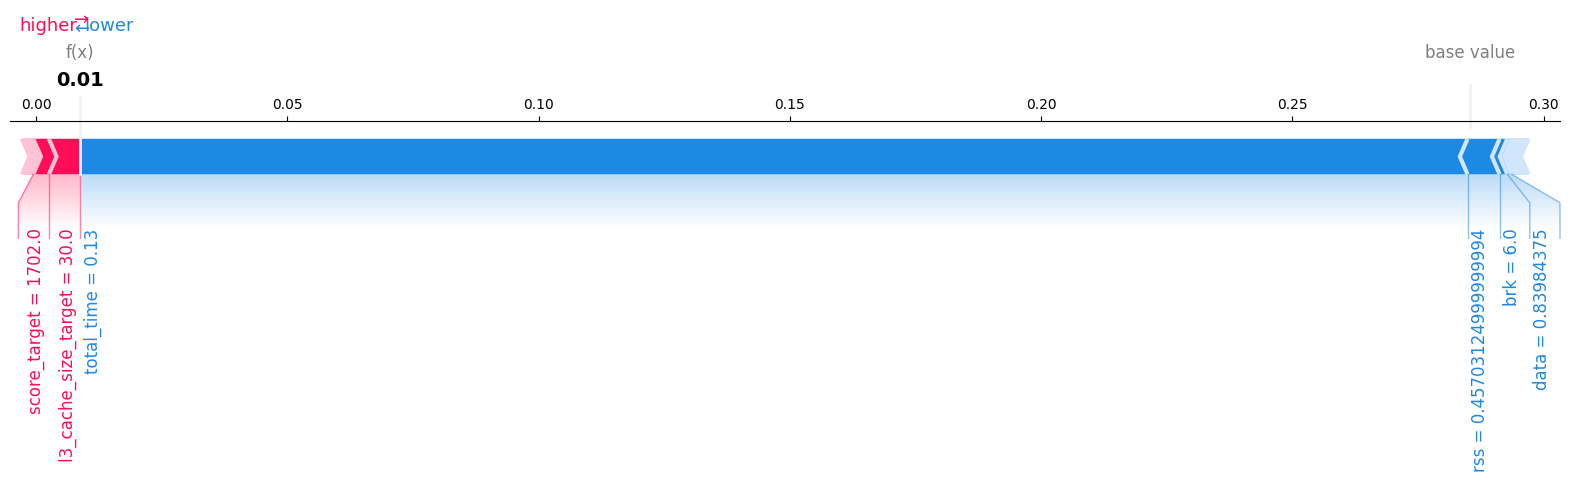

In [154]:
instance = 199
print(f"Prediction: {y_prediction[instance].item()} | Actual: {test_df_og.iloc[instance]['total_time_target']}")
shap.force_plot(explainer.expected_value, shap_values[instance], X_test_non_scaled[instance], feature_names=features, matplotlib=True, text_rotation=90)

Prediction: 9.235628128051758 | Actual: 9.51


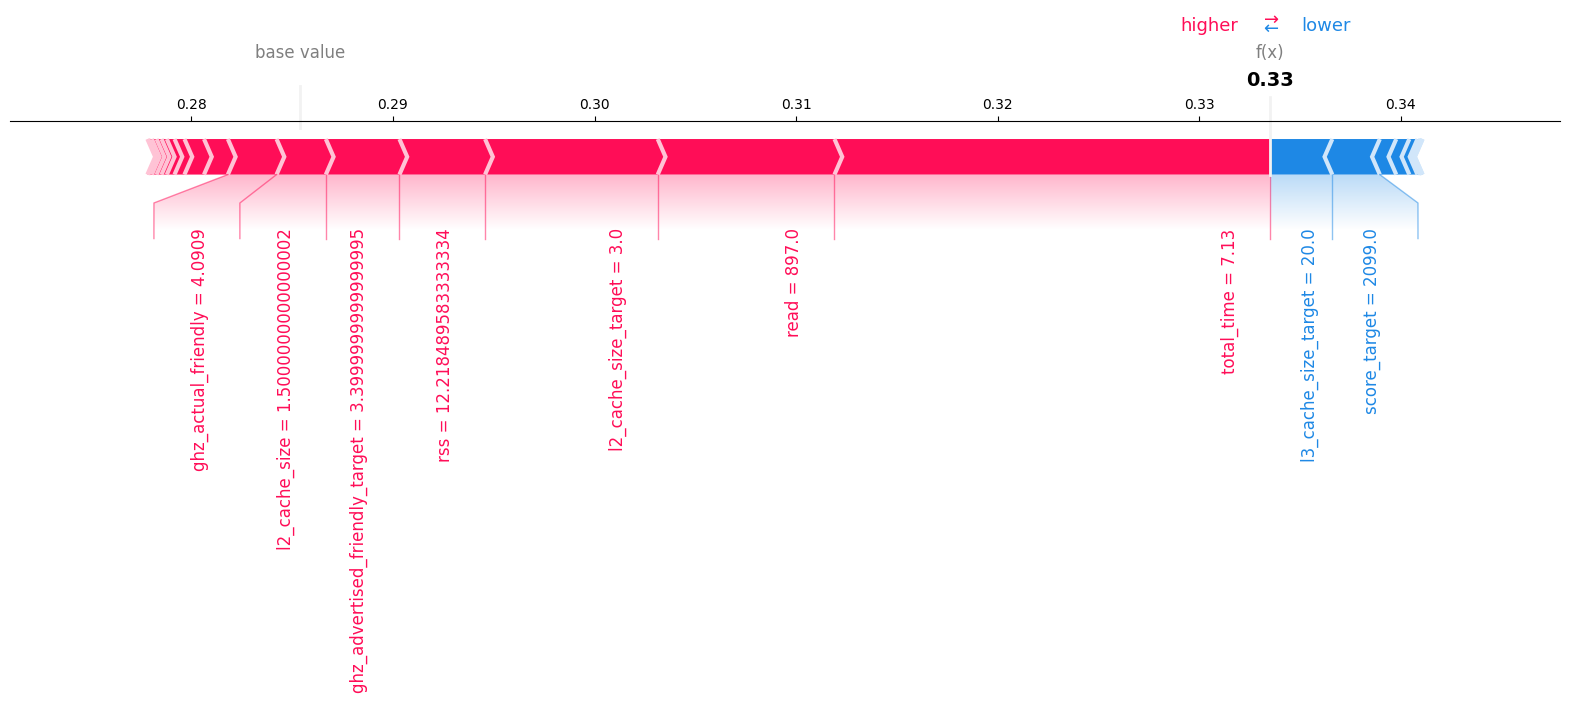

In [155]:
instance = 18
print(f"Prediction: {y_prediction[instance].item()} | Actual: {test_df_og.iloc[instance]['total_time_target']}")
shap.force_plot(explainer.expected_value, shap_values[instance], X_test_non_scaled[instance], feature_names=features, matplotlib=True, text_rotation=90)

Prediction: 233.05181884765625 | Actual: 218.37


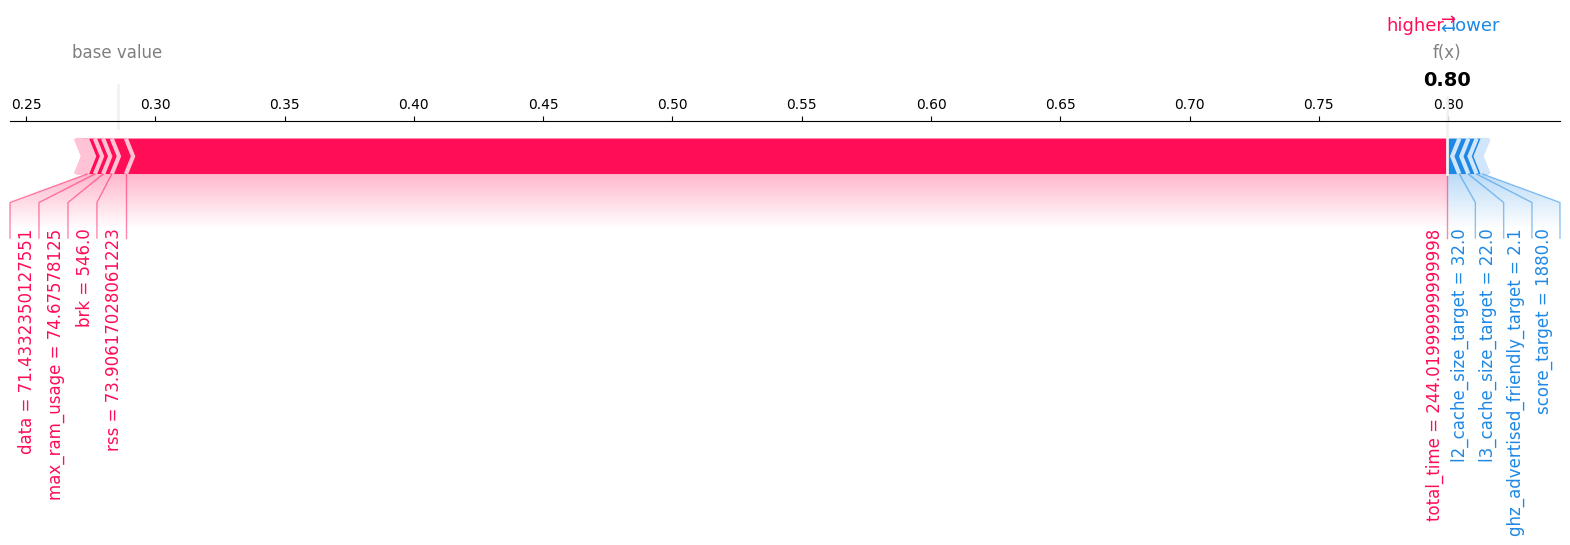

In [156]:
instance = 146
print(f"Prediction: {y_prediction[instance].item()} | Actual: {test_df_og.iloc[instance]['total_time_target']}")
shap.force_plot(explainer.expected_value, shap_values[instance], X_test_non_scaled[instance], feature_names=features, matplotlib=True, text_rotation=90)

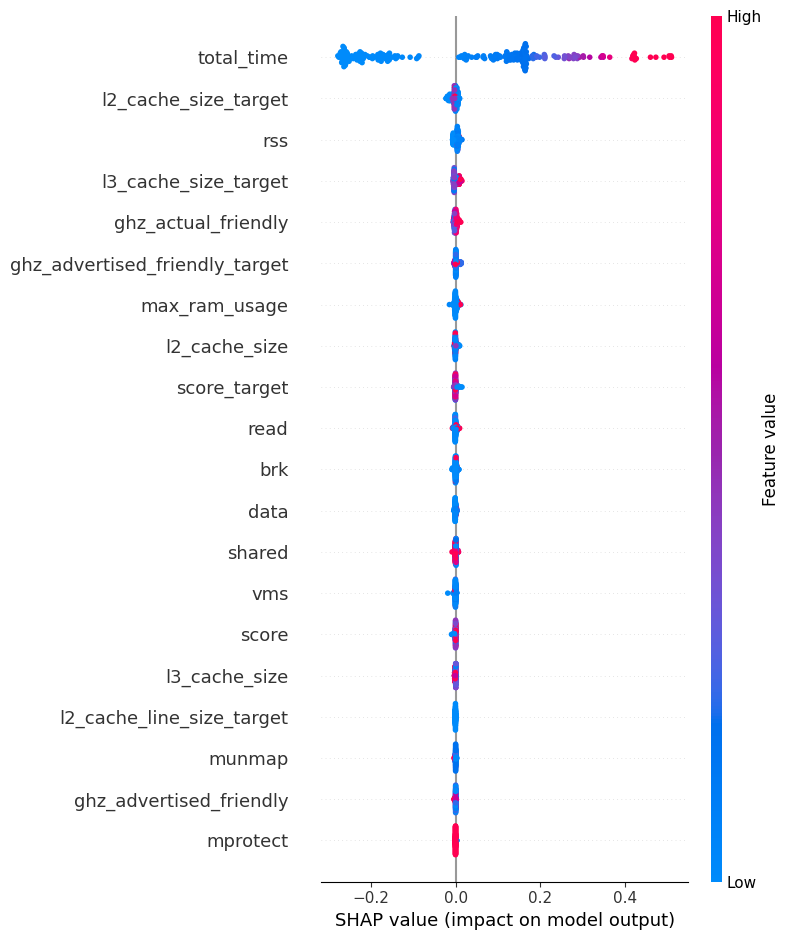

In [157]:
# Sumarize the effects of all the features
shap.summary_plot(shap_values, X_test_non_scaled, feature_names=features)

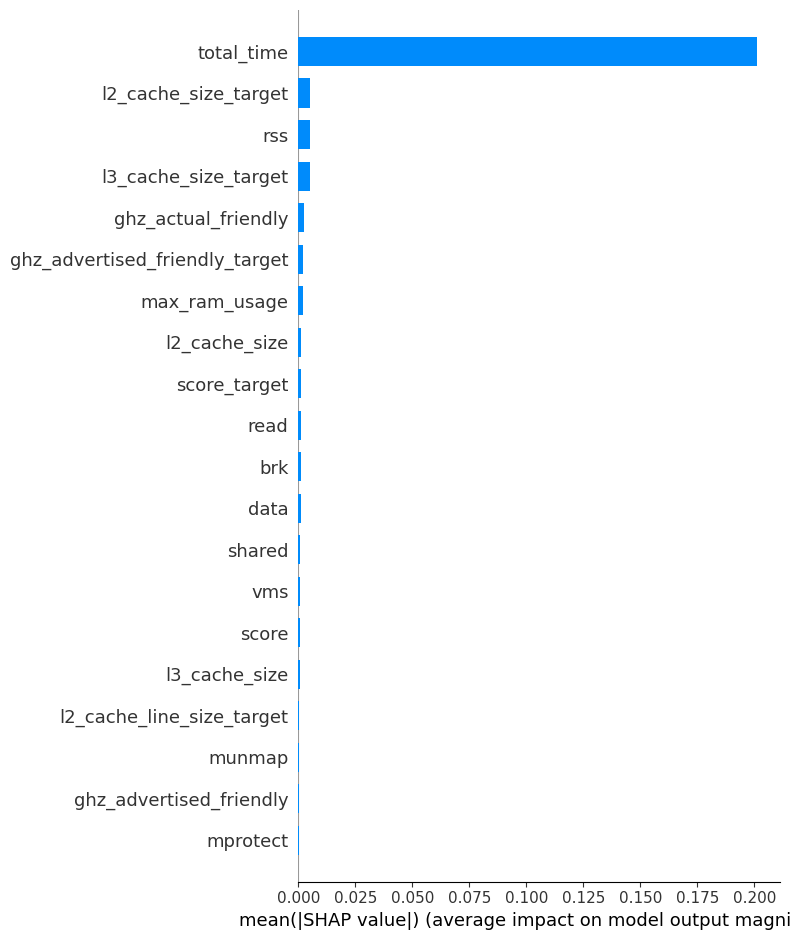

In [158]:
shap.summary_plot(shap_values, X_test_non_scaled, feature_names=features, plot_type='bar')

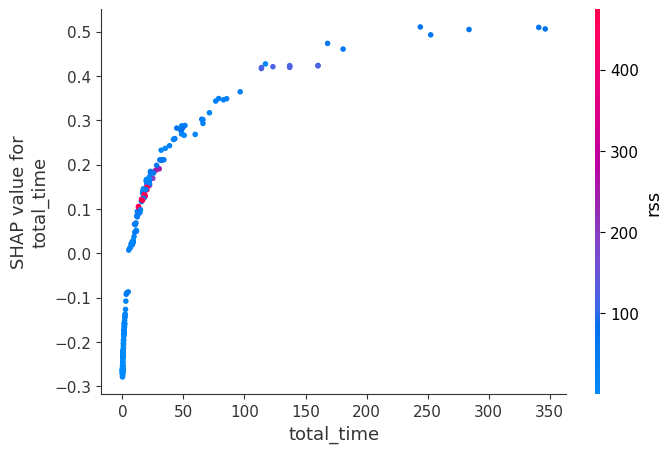

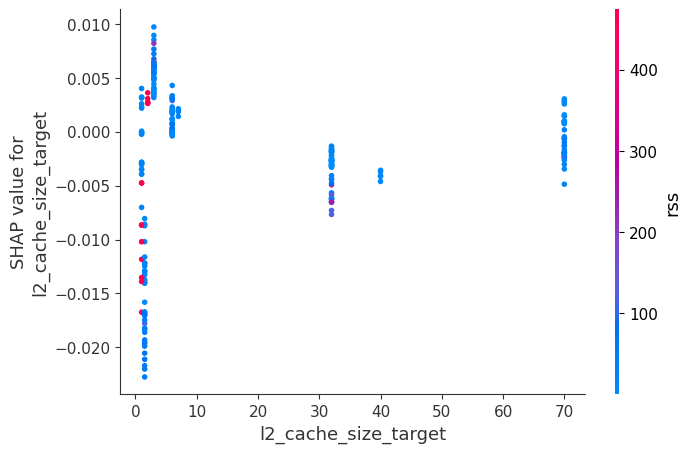

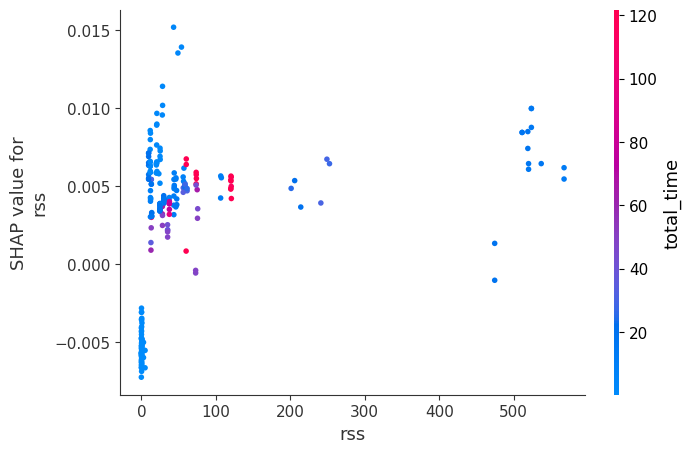

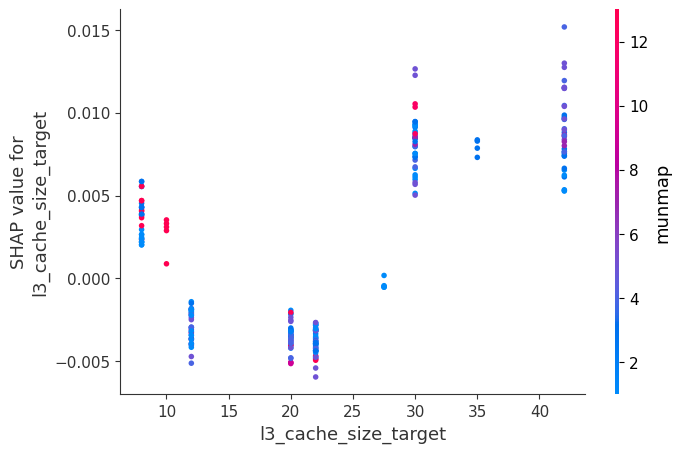

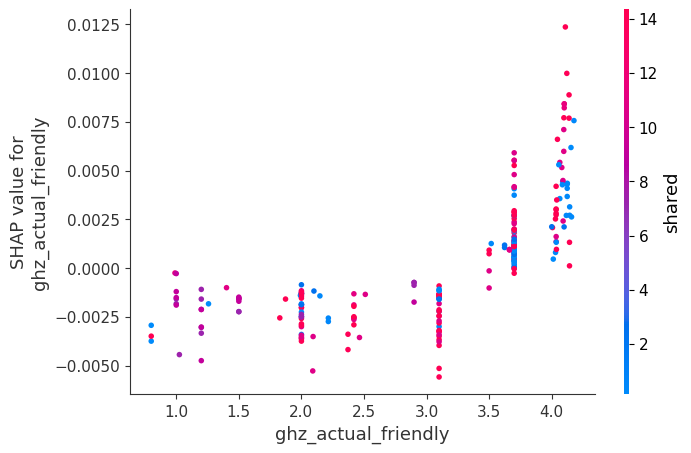

In [159]:
# sort the features indexes by their importance in the model
# (sum of SHAP value magnitudes over the test set)
# https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/League%20of%20Legends%20Win%20Prediction%20with%20XGBoost.html
top_inds = np.argsort(-np.sum(np.abs(shap_values), 0))
for i in range(5):
    # shap.common.approximate_interactions is used to pick what seems to be the strongest interaction 
    shap.dependence_plot(top_inds[i], shap_values, X_test_non_scaled, feature_names=features)